In [133]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from pybiomart import Server
from statsmodels import robust

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from networkx.algorithms.community.quality import modularity
import networkx as nx
from tqdm.auto import tqdm

In [49]:
#### PREPROCESSING ######

raw_expression = pd.read_csv('Team_4_STAD/TCGA.STAD.expression.txt', sep='\t')
metadata = pd.read_csv('Team_4_STAD/TCGA.STAD.metadata.txt', sep='\t')

id_cols = raw_expression.iloc[:, :2]

### Drop unknown HUGO genes
columns_to_drop = [col for col in raw_expression.columns if "?" in col]
raw_expression = raw_expression.drop(columns=columns_to_drop, axis=1)
# raw_expression.shape[1]
expression_values = raw_expression.iloc[:, 2:]

# Impute missing values
imputer = KNNImputer(n_neighbors=5)
imputed_expression = imputer.fit_transform(expression_values)

log2_expression = np.log2(imputed_expression + 1) # add 2 instead of 1?

gene_means = log2_expression.mean(axis=0)
gene_vars = log2_expression.var(axis=0)
gene_mads = np.apply_along_axis(robust.mad, axis=0, arr=log2_expression)

# Drop genes with low expression & variance
mean_threshold = 1
#var_threshold = 0.7
var_threshold = np.percentile(gene_vars, 20)
mad_threshold = np.median(gene_mads)

keep_genes = (gene_means > mean_threshold) & (gene_vars > var_threshold) & (gene_mads > mad_threshold)
filtered_expression = log2_expression[:, keep_genes]
# filtered_expression.shape[1]

scaler = StandardScaler()
scaled_expression = scaler.fit_transform(filtered_expression)
scaled_expression.shape[1]

9807

### Optimization
* Loop thru t-SNE with: init, perplexity, learning rate, max iterations, early exaggeration, distance metric
* Cluster with DBSCAN, HDBSCAN
* Assess Silhouette and Modularity Scores

In [50]:
### Function for computing modularity
def compute_modularity_score(data, labels, n_neighbors=10):
    """
    Computes modularity score for a clustering given a data matrix and cluster labels.
    Noise labels (-1) are removed.
    """
    # Step 1: Remove noise points
    non_noise_mask = labels != -1
    filtered_labels = labels[non_noise_mask]
    filtered_data = data[non_noise_mask]
    filtered_indices = np.where(non_noise_mask)[0]
    
    if len(set(filtered_labels)) <= 1:
        print("Too few clusters after noise removal to compute modularity.")
        return 0

    # Step 2: Build kNN graph (unweighted)
    knn_graph = kneighbors_graph(filtered_data, n_neighbors=n_neighbors, mode='connectivity', include_self=False)
    G = nx.from_scipy_sparse_array(knn_graph)

    # Step 3: Convert clustering into communities
    clusters = {}
    for node, label in zip(range(len(filtered_labels)), filtered_labels):
        clusters.setdefault(label, []).append(node)

    communities = list(clusters.values())

    # Step 4: Compute modularity
    mod_score = modularity(G, communities)
    if mod_score == None:
        mod_score = 0
        
    return mod_score


In [146]:
#### OPTIMIZATION PARAMETERS:
## First assessment of parameters
# perplexity = [5, 10, 20, 30, 40, 50, 70, 100]
# learning_rate =  [100, 200, 500]
# max_iter = [500, 1000, 2000]
# early_exaggeration =  [8 , 12 , 16]
# init = ['pca', 'random']
# metric = ['euclidean', 'cosine', 'correlation']

## Newly Adjusted parameters (after initial asseessment)
perplexity = [5, 10, 100]
learning_rate =  [100, 200, 500]
max_iter = [500, 1000, 2000]
early_exaggeration =  [8 , 16]
init = ['pca', 'random']
metric = ['euclidean', 'cosine', 'correlation']
eps = [0.5, 3, 5]

columns = [
    'perplexity',
    'learning_rate',
    'max_iter',
    'early_exaggeration',
    'init',
    'metric',
    'eps',
    'DBSCAN silhouette_score',
    'DBSCAN modularity',
    'KMEANS silhouette_score',
    'KMEANS modularity'
]

# Create an empty DataFrame with these columns
results_df = pd.DataFrame(columns=columns)

In [147]:
## Loop through everything
for perp in tqdm(perplexity):
    for learning in learning_rate:
        for maxi in max_iter:
            for ini in init:
                for met in metric:
                    for early in early_exaggeration:
                        for e in eps:

                            #### PART 1: t-SNE embedding:
                            tsne = TSNE(n_components=2, perplexity=perp, learning_rate=learning, max_iter=maxi, init=ini, metric=met, early_exaggeration=early, random_state=42)
                            tsne_embedding = tsne.fit_transform(scaled_expression)
                            
                            # Make into a DataFrame and re-attach IDs
                            tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
                            tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)
                            
                            # plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=10, alpha=0.4)
                            # plt.title('t-SNE Embedding')
                            # plt.show()
                            
                            
                            #### PART 2: CLUSTERING & ASSESSMENT
                            
                            ######## DBSCAN
                            dbscan = DBSCAN(eps=e, min_samples=5)
                            dbscan_labels = dbscan.fit_predict(tsne_embedding)
                            
                            # -------> Silhouette scoring: Remove noise (-1 labels) before
                            valid_dbscan_mask = dbscan_labels != -1
                            if len(set(dbscan_labels[valid_dbscan_mask])) > 1:
                                dbscan_silhouette = silhouette_score(tsne_embedding[valid_dbscan_mask], dbscan_labels[valid_dbscan_mask])
                                # print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
                            else:
                                print("DBSCAN found too few clusters for silhouette score.")
                            
                            # -------> Modularity:                        
                            mod_score_dbscan = compute_modularity_score(tsne_embedding, db_labels, n_neighbors=10)
                            # print(f"DBSCAN Modularity: {mod_score_dbscan:.3f}")
                            
                            ####### KMEANS
                            kmeans = KMeans(n_clusters=5, random_state=42)
                            kmeans_labels = kmeans.fit_predict(tsne_embedding)
                            
                            # -------> Silhouette
                            kmeans_silhouette = silhouette_score(tsne_embedding, kmeans_labels)
                            # print(f"K-means Silhouette Score: {kmeans_silhouette:.3f}")
                            
                            # -------> Modularity
                            mod_score_kmeans = compute_modularity_score(tsne_embedding, kmeans_labels, n_neighbors=10)
                            # print(f"K-means Modularity: {mod_score_kmeans:.3f}")
                            
                            ### Store Silhoutte & Modularity Scores
                            param_list =  [     
                                perp,
                                learning,
                                maxi,
                                early,
                                ini,
                                met,
                                e,
                                dbscan_silhouette,
                                mod_score_dbscan,
                                kmeans_silhouette,
                                mod_score_kmeans
                            ] # replace with actual variable name for iteration
                            
                            results_df.loc[len(results_df)] = param_list


  0%|          | 0/3 [00:00<?, ?it/s]

DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found too few clusters for silhouette score.
DBSCAN found

### Retrieve parameters with the highest modularity + silhouette scores for DBSCAN and K-means

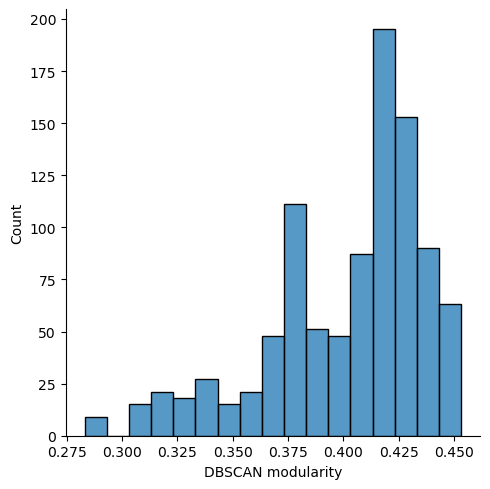

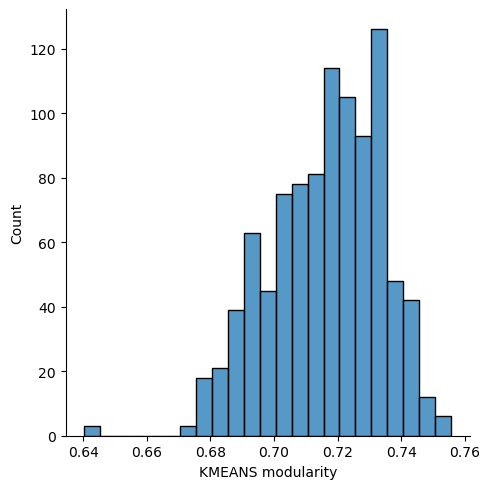

In [148]:
# should have 972 rows
sns.displot(results_df['DBSCAN modularity'])
sns.displot(results_df['KMEANS modularity'])

In [168]:
best_dbscan_mod = results_df[results_df['DBSCAN modularity'] == results_df['DBSCAN modularity'].max()]
best_dbscan_mod.reset_index(drop=True, inplace=True)
best_dbscan_mod
# print(best_dbscan_mod.to_numpy().tolist())

,perplexity,learning_rate,max_iter,early_exaggeration,init,metric,eps,DBSCAN silhouette_score,DBSCAN modularity,KMEANS silhouette_score,KMEANS modularity
0,5,500,1000,8,pca,correlation,0.5,0.440631,0.453294,0.373137,0.753825
1,5,500,1000,8,pca,correlation,3.0,0.684706,0.453294,0.373137,0.753825
2,5,500,1000,8,pca,correlation,5.0,0.503265,0.453294,0.373137,0.753825


In [167]:
best_hdbscan_mod = results_df[results_df['KMEANS modularity'] == results_df['KMEANS modularity'].max()]
best_hdbscan_mod.reset_index(drop=True, inplace=True)
best_hdbscan_mod
# print(best_hdbscan_mod.to_numpy().tolist())

,perplexity,learning_rate,max_iter,early_exaggeration,init,metric,eps,DBSCAN silhouette_score,DBSCAN modularity,KMEANS silhouette_score,KMEANS modularity
0,10,200,2000,16,random,correlation,0.5,0.308418,0.421276,0.42026,0.75572
1,10,200,2000,16,random,correlation,3.0,0.605999,0.421276,0.42026,0.75572
2,10,200,2000,16,random,correlation,5.0,0.204875,0.421276,0.42026,0.75572


In [166]:
best_dbscan_sil = results_df[results_df['DBSCAN silhouette_score'] == results_df['DBSCAN silhouette_score'].max()]
best_dbscan_sil.reset_index(drop=True, inplace=True)
best_dbscan_sil
# print(best_dbscan_sil.to_numpy().tolist())

,perplexity,learning_rate,max_iter,early_exaggeration,init,metric,eps,DBSCAN silhouette_score,DBSCAN modularity,KMEANS silhouette_score,KMEANS modularity
0,5,500,2000,16,random,correlation,3.0,0.86437,0.41225,0.400139,0.74158


In [165]:
best_hdbscan_sil = results_df[results_df['KMEANS silhouette_score'] == results_df['KMEANS silhouette_score'].max()]
best_hdbscan_sil.reset_index(drop=True, inplace=True)
best_hdbscan_sil
# print(best_hdbscan_sil.to_numpy().tolist())

,perplexity,learning_rate,max_iter,early_exaggeration,init,metric,eps,DBSCAN silhouette_score,DBSCAN modularity,KMEANS silhouette_score,KMEANS modularity
0,5,500,2000,8,random,cosine,0.5,0.529000,0.4504,0.459712,0.747823
1,5,500,2000,8,random,cosine,3.0,0.814907,0.4504,0.459712,0.747823
2,5,500,2000,8,random,cosine,5.0,0.550161,0.4504,0.459712,0.747823


### Plot Clustering of Best Modularity + Silhouette Scores
* Also merge with metadata (race data)

In [172]:
### MERGING with metadata
merged = pd.merge(tsne_df, metadata, on='patient_id') # merge embedding with metadata

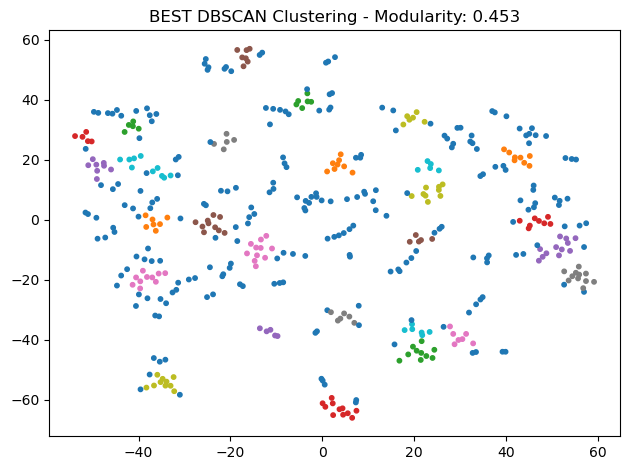

In [173]:
## BEST DBSCAN MODULARITY
tsne = TSNE(n_components=2, perplexity=best_dbscan_mod.loc[0,'perplexity'], learning_rate=best_dbscan_mod.loc[0,'learning_rate'], max_iter=best_dbscan_mod.loc[0,'max_iter'], init=best_dbscan_mod.loc[0,'init'], metric=best_dbscan_mod.loc[0,'metric'], early_exaggeration=best_dbscan_mod.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=dbscan_labels, cmap='tab10', s=10)
value = best_dbscan_mod.loc[0,'DBSCAN modularity']
plt.title(f"BEST DBSCAN Clustering - Modularity: {value:.3f}")

plt.tight_layout()
plt.show()

## Metadata Overlay
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=merged, x='tSNE-1', y='tSNE-2', hue='race', style='race', palette='Set3')
# plt.title('t-SNE, DBSCAN, best Modularity: Race')
# plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2, frameon=False) # below
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # to the right
# plt.tight_layout()
# plt.show()

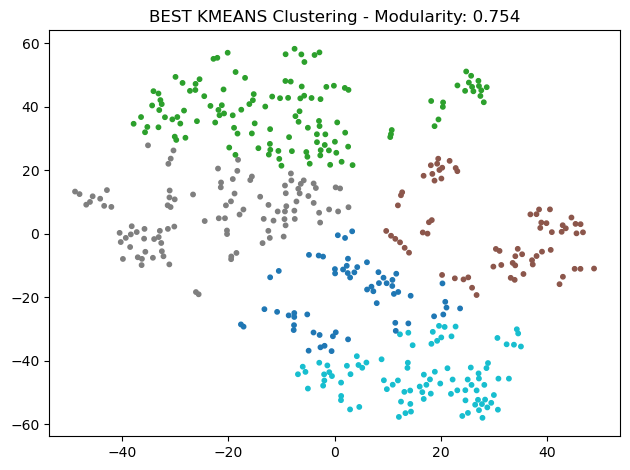

In [180]:
## BEST KMEANS MODULARITY
tsne = TSNE(n_components=2, perplexity=best_hdbscan_mod.loc[0,'perplexity'], learning_rate=best_hdbscan_mod.loc[0,'learning_rate'], max_iter=best_hdbscan_mod.loc[0,'max_iter'], init=best_hdbscan_mod.loc[0,'init'], metric=best_hdbscan_mod.loc[0,'metric'], early_exaggeration=best_hdbscan_mod.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=kmeans_labels, cmap='tab10', s=10)
value = best_dbscan_mod.loc[0,'KMEANS modularity']
plt.title(f"BEST KMEANS Clustering - Modularity: {value:.3f}")

plt.tight_layout()
plt.show()

# Metadata Overlay
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=merged, x='tSNE-1', y='tSNE-2', hue='race', style='race', palette='Set3')
# plt.title('t-SNE, HDBSCAN, best Modularity: Race')
# plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2, frameon=False) # below
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # to the right
# plt.tight_layout()
# plt.show()

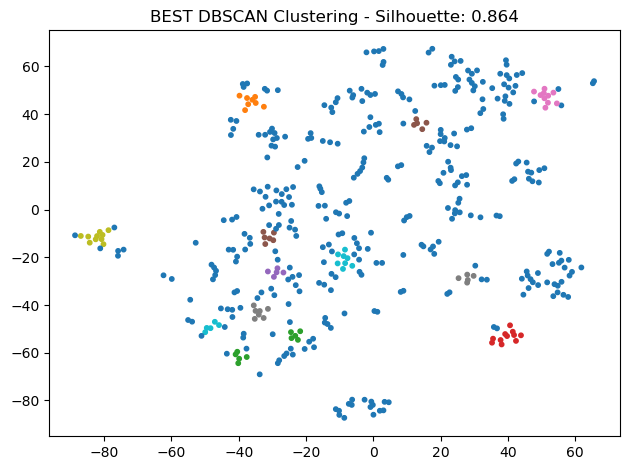

In [175]:
## BEST DBSCAN SILHOUETTE
tsne = TSNE(n_components=2, perplexity=best_dbscan_sil.loc[0,'perplexity'], learning_rate=best_dbscan_sil.loc[0,'learning_rate'], max_iter=best_dbscan_sil.loc[0,'max_iter'], init=best_dbscan_sil.loc[0,'init'], metric=best_dbscan_sil.loc[0,'metric'], early_exaggeration=best_dbscan_sil.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=dbscan_labels, cmap='tab10', s=10)
value = best_dbscan_sil.loc[0,'DBSCAN silhouette_score']
plt.title(f"BEST DBSCAN Clustering - Silhouette: {value:.3f}")

plt.tight_layout()
plt.show()

## Metadata Overlay
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=merged, x='tSNE-1', y='tSNE-2', hue='race', style='race', palette='Set3')
# plt.title('t-SNE, DBSCAN, Best Silhouette: Race')
# plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2, frameon=False) # below
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # to the right
# plt.tight_layout()
# plt.show()

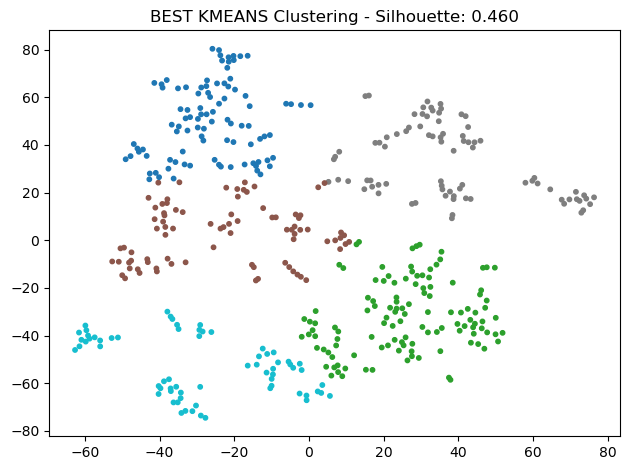

In [182]:
## BEST KMEANS SILHOUETTE
tsne = TSNE(n_components=2, perplexity=best_hdbscan_sil.loc[0,'perplexity'], learning_rate=best_hdbscan_sil.loc[0,'learning_rate'], max_iter=best_hdbscan_sil.loc[0,'max_iter'], init=best_hdbscan_sil.loc[0,'init'], metric=best_hdbscan_sil.loc[0,'metric'], early_exaggeration=best_hdbscan_sil.loc[0,'early_exaggeration'], random_state=42)
tsne_embedding = tsne.fit_transform(scaled_expression)

# Make into a DataFrame and re-attach IDs
tsne_df = pd.DataFrame(tsne_embedding, columns=['tSNE-1', 'tSNE-2'])
tsne_df = pd.concat([id_cols.reset_index(drop=True), tsne_df], axis=1)

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(tsne_embedding)

plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], c=kmeans_labels, cmap='tab10', s=10)
value = best_hdbscan_sil.loc[0,'KMEANS silhouette_score']
plt.title(f"BEST KMEANS Clustering - Silhouette: {value:.3f}")

plt.tight_layout()
plt.show()

# Metadata Overlay
# plt.figure(figsize=(8,6))
# sns.scatterplot(data=merged, x='tSNE-1', y='tSNE-2', hue='race', style='race', palette='Set3')
# plt.title('t-SNE, HDBSCAN, Best Silhouette: Race')
# plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=2, frameon=False) # below
# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # to the right
# plt.tight_layout()
# plt.show()